In [1]:
import os

import torch
import numpy as np
import pandas as pd

import scipy.io
import scipy
import scipy.signal

from multiprocessing import Pool

import matplotlib.pyplot as plt
plt.style.use('dark_background')

In [2]:
labels = scipy.io.loadmat('./SEED_EEG/Preprocessed_EEG/label.mat')
print(labels.keys())

dict_keys(['__header__', '__version__', '__globals__', 'label'])


In [3]:
sub1_exp1 = scipy.io.loadmat('./SEED_EEG/ExtractedFeatures/1_20131027.mat')
print(sub1_exp1.keys())

dict_keys(['__header__', '__version__', '__globals__', 'de_movingAve1', 'de_LDS1', 'psd_movingAve1', 'psd_LDS1', 'dasm_movingAve1', 'dasm_LDS1', 'rasm_movingAve1', 'rasm_LDS1', 'asm_movingAve1', 'asm_LDS1', 'dcau_movingAve1', 'dcau_LDS1', 'de_movingAve2', 'de_LDS2', 'psd_movingAve2', 'psd_LDS2', 'dasm_movingAve2', 'dasm_LDS2', 'rasm_movingAve2', 'rasm_LDS2', 'asm_movingAve2', 'asm_LDS2', 'dcau_movingAve2', 'dcau_LDS2', 'de_movingAve3', 'de_LDS3', 'psd_movingAve3', 'psd_LDS3', 'dasm_movingAve3', 'dasm_LDS3', 'rasm_movingAve3', 'rasm_LDS3', 'asm_movingAve3', 'asm_LDS3', 'dcau_movingAve3', 'dcau_LDS3', 'de_movingAve4', 'de_LDS4', 'psd_movingAve4', 'psd_LDS4', 'dasm_movingAve4', 'dasm_LDS4', 'rasm_movingAve4', 'rasm_LDS4', 'asm_movingAve4', 'asm_LDS4', 'dcau_movingAve4', 'dcau_LDS4', 'de_movingAve5', 'de_LDS5', 'psd_movingAve5', 'psd_LDS5', 'dasm_movingAve5', 'dasm_LDS5', 'rasm_movingAve5', 'rasm_LDS5', 'asm_movingAve5', 'asm_LDS5', 'dcau_movingAve5', 'dcau_LDS5', 'de_movingAve6', 'de_LDS6

In [4]:
print(sub1_exp1["de_movingAve1"].shape)
print(sub1_exp1["de_movingAve1"][:18].min())
print(sub1_exp1["de_movingAve1"][:18].max())

(62, 235, 5)
14.557908737579552
35.222892853866405


In [16]:
def plot_psd(data, subject=0, channel=0, fs=100):
    x_t = data[subject][channel]

    N = x_t.shape[-1]
    t = torch.arange(0, N) * 1/fs

    plt.figure(figsize=(15, 4))

    plt.subplot(211)
    plt.plot(t, x_t)
    plt.xlabel('t [s]')
    plt.ylabel('x(t)')

    plt.subplot(212)
    plt.psd(x_t, 1024, fs)
    plt.xlabel('f [Hz]')

    plt.tight_layout()
    plt.show()

#### Get all files

In [2]:
def get_all_files(rootdir):
    files = []
    for file in os.listdir(rootdir):
        curr_object = os.path.join(rootdir, file)

        if os.path.isdir(curr_object):
            files += get_all_files(curr_object)
        elif '_' in file and ".mat" in file:
            files.append(curr_object)

    return files

In [3]:
data_path = "/mnt/storage0/oturgut/data/SEED/SEED_EEG/Preprocessed_EEG/"

files = get_all_files(data_path)
files = sorted(files)
print(len(files))
print(files[:5])

45
['/mnt/storage0/oturgut/data/SEED/SEED_EEG/Preprocessed_EEG/10_20131130.mat', '/mnt/storage0/oturgut/data/SEED/SEED_EEG/Preprocessed_EEG/10_20131204.mat', '/mnt/storage0/oturgut/data/SEED/SEED_EEG/Preprocessed_EEG/10_20131211.mat', '/mnt/storage0/oturgut/data/SEED/SEED_EEG/Preprocessed_EEG/11_20140618.mat', '/mnt/storage0/oturgut/data/SEED/SEED_EEG/Preprocessed_EEG/11_20140625.mat']


#### Load the data

In [4]:
def load_data(file):
    return scipy.io.loadmat(file)

In [5]:
num_processes = 24
with Pool(processes=num_processes) as pool:
    results = pool.map(load_data, files)

exp_all = results
print(len(exp_all))
print(exp_all[0]["ww_eeg12"].shape)

45
(62, 46601)


In [6]:
min_length = 1000000
min_sample = ''
nb_samples = 0

for exp in exp_all:
    for name in exp.keys():
        if 'eeg' in name:
            nb_samples += 1
            if exp[name].shape[-1] < min_length:
                min_length = exp[name].shape[-1]
                min_sample = name

print(min_sample)
print(min_length)
print(nb_samples)

ww_eeg5
37001
675


In [7]:
# read the channel order
chOrder = pd.read_excel("/mnt/storage0/oturgut/data/SEED/SEED_EEG/channel-order.xlsx", header=None)
chOrder

,0
0,FP1
1,FPZ
2,FP2
3,AF3
4,AF4
...,...
57,CB1
58,O1
59,OZ
60,O2


In [8]:
chOrder_list = [ch.item() for ch in chOrder.values]
print(chOrder_list)

['FP1', 'FPZ', 'FP2', 'AF3', 'AF4', 'F7', 'F5', 'F3', 'F1', 'FZ', 'F2', 'F4', 'F6', 'F8', 'FT7', 'FC5', 'FC3', 'FC1', 'FCZ', 'FC2', 'FC4', 'FC6', 'FT8', 'T7', 'C5', 'C3', 'C1', 'CZ', 'C2', 'C4', 'C6', 'T8', 'TP7', 'CP5', 'CP3', 'CP1', 'CPZ', 'CP2', 'CP4', 'CP6', 'TP8', 'P7', 'P5', 'P3', 'P1', 'PZ', 'P2', 'P4', 'P6', 'P8', 'PO7', 'PO5', 'PO3', 'POZ', 'PO4', 'PO6', 'PO8', 'CB1', 'O1', 'OZ', 'O2', 'CB2']


In [9]:
chOrder_standard_tuab = ['EEG FP1-REF', 'EEG FP2-REF', 'EEG F3-REF', 'EEG F4-REF', 'EEG C3-REF', 'EEG C4-REF', 'EEG P3-REF', 'EEG P4-REF', 'EEG O1-REF', 'EEG O2-REF', 'EEG F7-REF', \
                         'EEG F8-REF', 'EEG T3-REF', 'EEG T4-REF', 'EEG T5-REF', 'EEG T6-REF', 'EEG FZ-REF', 'EEG CZ-REF', 'EEG PZ-REF']

In [10]:
chOrder_new = ['FP1', 'FP2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'FZ', 'CZ', 'PZ']

In [11]:
chOrder_new_indices = [idx for i in chOrder_new for idx, j in enumerate(chOrder_list) if i==j]
chOrder_new_indices

[0, 2, 7, 11, 25, 29, 43, 47, 58, 60, 5, 13, 23, 31, 41, 49, 9, 27, 45]

#### Filter and crop to minimum length

In [12]:
data = []
for exp in exp_all:
    keys = list(exp.keys())
    recs = [exp[key] for key in keys if 'eeg' in key]

    for rec in recs:
        data.append(rec[chOrder_new_indices][..., :min_length])

In [13]:
len(data)

675

In [15]:
data[12].shape

(19, 37001)

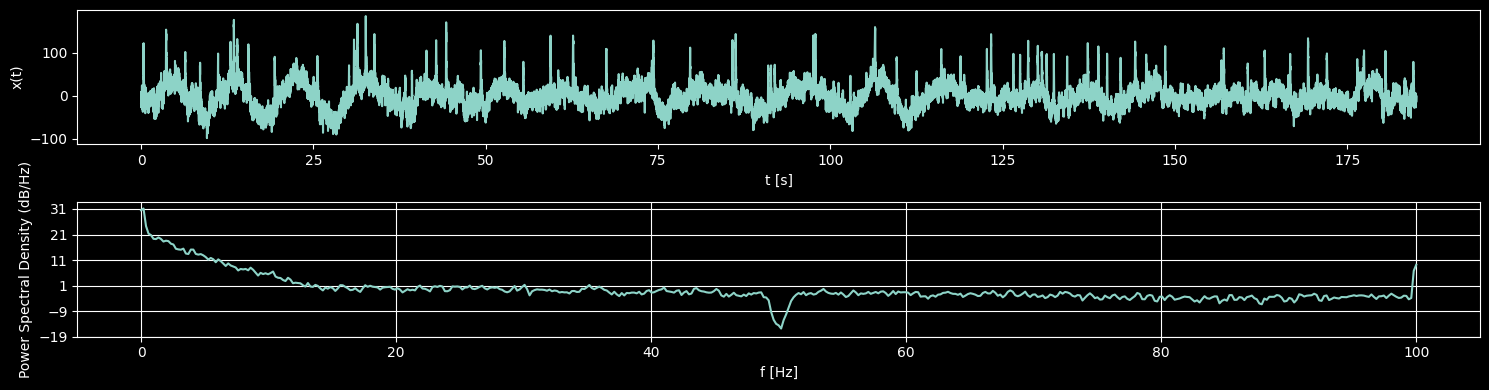

In [17]:
subject = 0
channel = 0
fs = 200
plot_psd(data, subject=subject, channel=channel, fs=fs)

#### Normalise

In [21]:
def normalise(sample):
    return (sample - sample.mean(axis=-1, keepdims=True) ) / ( sample.std(axis=-1, keepdims=True) + 1e-9 )

num_processes = 24
with Pool(processes=num_processes) as pool:
    data_normalised = pool.map(normalise, data)

print(len(data_normalised))
print(data_normalised[0].shape)

675
(19, 37001)


In [26]:
data_normalised[500].min(), data_normalised[500].max()

(-10.093001131529526, 8.087329313920709)

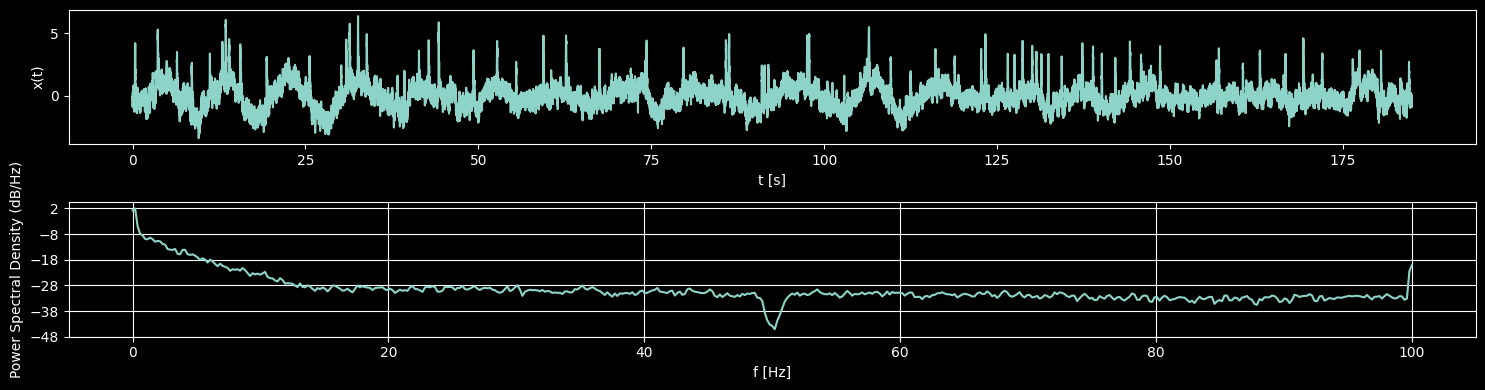

In [22]:
subject = 0
channel = 0
fs = 200
plot_psd(data_normalised, subject=subject, channel=channel, fs=fs)

#### Convert into correct format

In [32]:
data_seed = [("eeg_10-20", torch.tensor(sample, dtype=torch.float32)) for sample in data_normalised]

In [34]:
data_seed[0][1].shape, data_seed[0][1].dtype

(torch.Size([1, 19, 37001]), torch.float32)

In [35]:
# torch.save(data_seed, "/home/oturgut/data/processed/SEED/data_seed_all.pt")

#### Apply notch filter (was already done by data provider)

In [18]:
fs = 200 # sampling frequency
notch_freq = 50 # frequency to be removed
quality_factor = 20

b_notch, a_notch = scipy.signal.iirnotch(w0=notch_freq, Q=quality_factor, fs=fs)

In [19]:
data_filtered = scipy.signal.filtfilt(b_notch, a_notch, data[0])

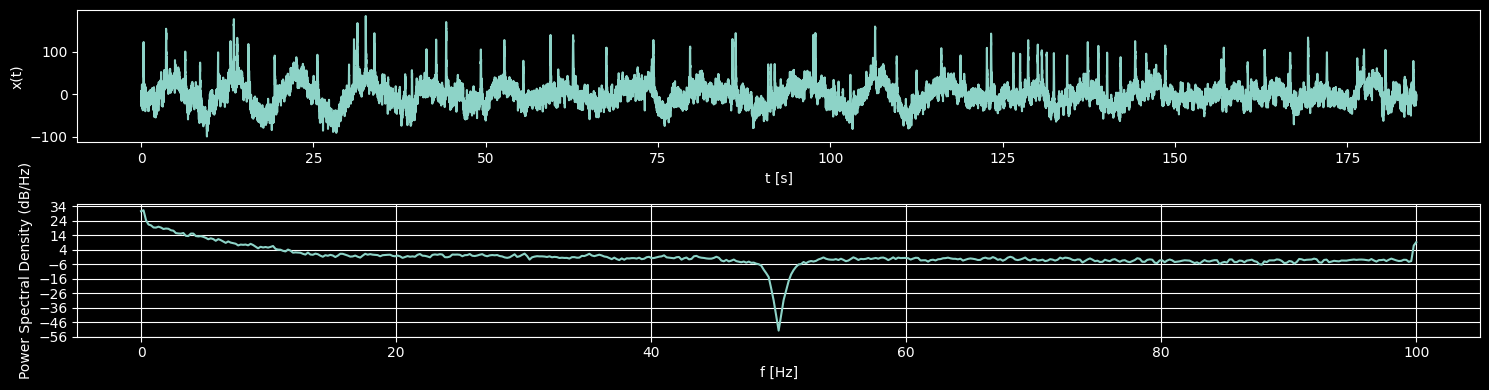

In [20]:
subject = 0
channel = 0
fs = 200
plot_psd(data_filtered[None, ...], subject=subject, channel=channel, fs=fs)

### Summarize all 15 trials of an experiment in one recording

In [10]:
recordings = []
for exp in exp_all:
    keys = list(exp.keys())
    recs = [exp[key] for key in keys if 'eeg' in key]

    subject_recording = torch.tensor([])
    for i, rec in enumerate(recs):
        # print("EEG Recording %2d - shape %s" % (i+1, rec.shape))
        
        eeg_recording = torch.full(size=(65, rec.shape[-1]), fill_value=12345.6789)

        sample = torch.from_numpy(rec)
        nb_missing_ch = 65 - rec.shape[0] 

        eeg_recording = torch.cat((sample, sample[:nb_missing_ch]), dim=0)

        subject_recording = torch.cat((subject_recording, eeg_recording), dim=-1)

    recordings.append(subject_recording)

In [11]:
recordings[0].shape

torch.Size([65, 678815])

In [12]:
recordings_100Hz = [rec[..., ::2] for rec in recordings]

In [13]:
seed_recordings = torch.tensor([])

for rec in recordings_100Hz:
    seed_recordings = torch.cat((seed_recordings, rec[None, ...]), dim=0)

In [14]:
seed_recordings.shape

torch.Size([45, 65, 339408])

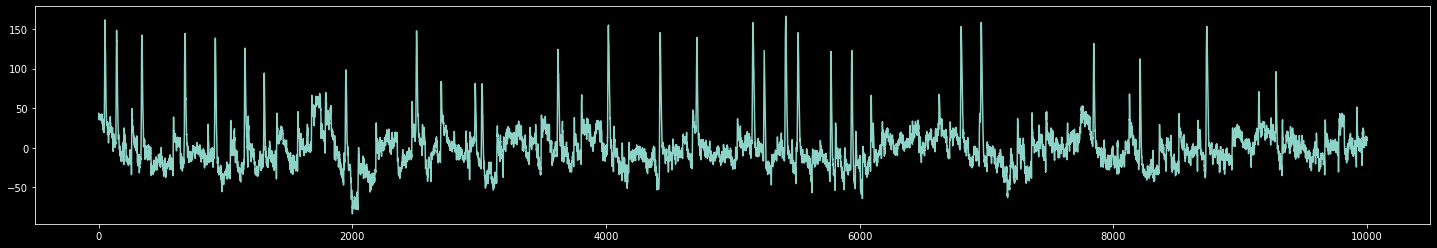

In [57]:
plt.figure(figsize=(25, 4))
plt.plot(seed_recordings[12, 0, :10000])
plt.show()

In [16]:
def filter(data, fs=100, order=10, f_cutoff=45):
    sos_filter = scipy.signal.butter(order, f_cutoff, 'lp', fs=fs, output='sos')
    data_filtered = scipy.signal.sosfilt(sos_filter, data)

    return torch.tensor(data_filtered, dtype=torch.float32)

In [17]:
data_filtered = filter(seed_recordings, fs=100, f_cutoff=45)

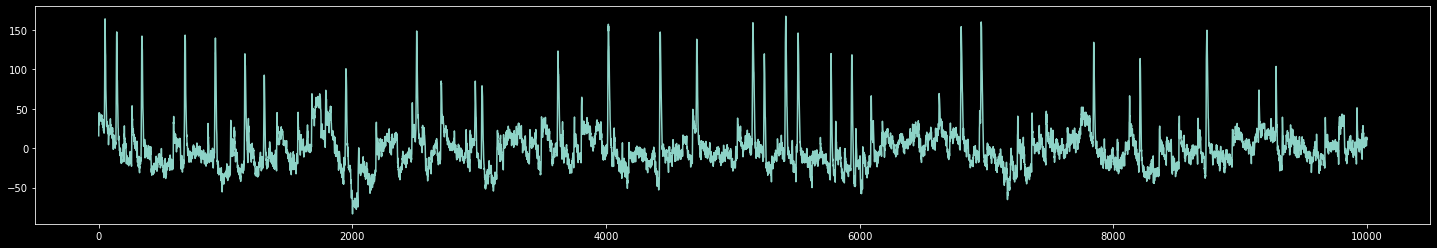

In [56]:
plt.figure(figsize=(25, 4))
plt.plot(data_filtered[12, 0, :10000])
plt.show()

In [23]:
def normalize(data):
    mean = torch.mean(data, dim=-1, keepdim=True)
    var = torch.var(data, dim=-1, keepdim=True)

    data_normalized = (data - mean) / (var + 1.e-12)**.5

    return data_normalized

In [24]:
data_normalized = normalize(data_filtered)

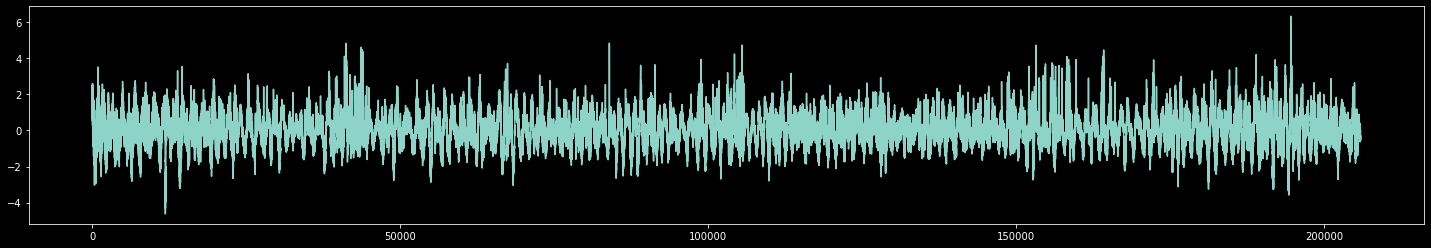

In [50]:
plt.figure(figsize=(25, 4))
plt.plot(data_normalized[34, 0, :205900])
plt.show()

In [38]:
def clamp(data, min=-3, max=3):
    return torch.clamp(data, min=min, max=max)

In [39]:
data_clamped = clamp(data_normalized)

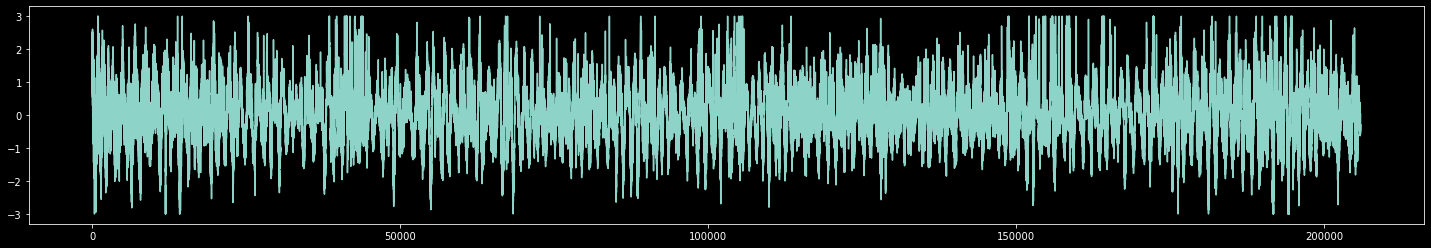

In [51]:
plt.figure(figsize=(25, 4))
plt.plot(data_clamped[34, 0, :205900])
plt.show()

In [52]:
data_clamped.shape

torch.Size([45, 65, 339408])

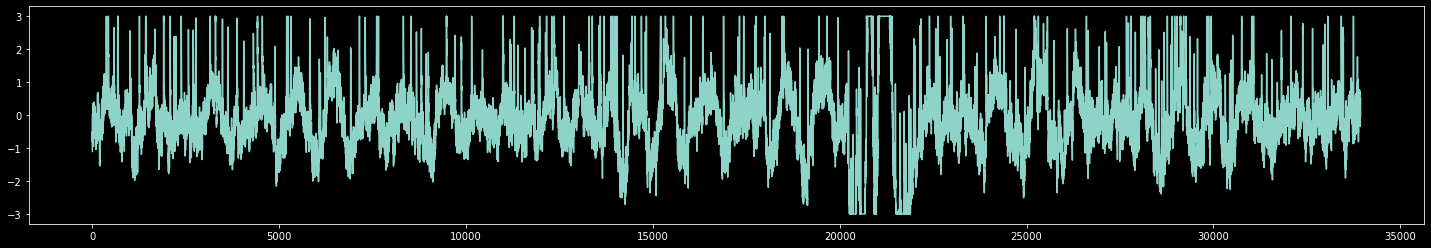

In [66]:
plt.figure(figsize=(25, 4))
plt.plot(data_clamped[0, 0, 33940:67880])
plt.show()

In [87]:
data_reshaped = torch.cat(torch.split(data_clamped[..., :-8], 33940, dim=-1), dim=0)

In [88]:
data_reshaped.shape

torch.Size([450, 65, 33940])

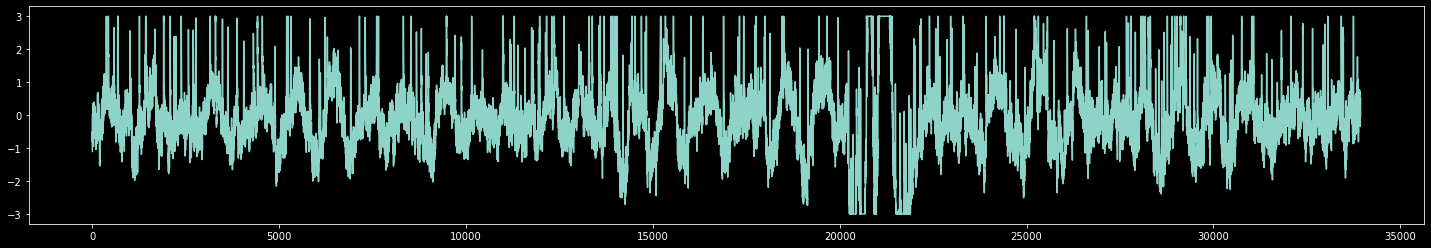

In [89]:
plt.figure(figsize=(25, 4))
plt.plot(data_reshaped[45, 0, :])
plt.show()

In [92]:
data_reshaped.dtype

torch.float64

In [93]:
# torch.save(data_reshaped.to(dtype=torch.float32), '/home/oturgut/sprai/data/preprocessed/eeg/data_SEED_bw45_cw_clamped_fs100.pt')

In [95]:
data_lemon = torch.load("/home/oturgut/sprai/data/preprocessed/eeg/data_LEMON_train_joined_bw45_cw_clamped_fs100.pt")

In [96]:
print(data_reshaped.shape, data_lemon.shape)

torch.Size([450, 65, 33940]) torch.Size([282, 65, 40442])


In [101]:
data_joined = torch.cat((data_reshaped, data_lemon[..., :33940]), dim=0).to(dtype=torch.float32)

In [102]:
data_joined.dtype

torch.float32

In [103]:
# torch.save(data_joined.to(dtype=torch.float32), '/home/oturgut/sprai/data/preprocessed/eeg/data_LEMONSEED_bw45_cw_clamped_fs100.pt')

Just the experiment 1 of subject 5

In [28]:
sub1_exp1 = scipy.io.loadmat('/home/oturgut/sprai/data/datasets/SEED/SEED_EEG/Preprocessed_EEG/5_20140411.mat')
print(sub1_exp1.keys())

dict_keys(['__header__', '__version__', '__globals__', 'ly_eeg1', 'ly_eeg2', 'ly_eeg3', 'ly_eeg4', 'ly_eeg5', 'ly_eeg6', 'ly_eeg7', 'ly_eeg8', 'ly_eeg9', 'ly_eeg10', 'ly_eeg11', 'ly_eeg12', 'ly_eeg13', 'ly_eeg14', 'ly_eeg15'])


In [29]:
sub1_exp1['ly_eeg3'].shape

(62, 41201)

In [6]:
min_length = 1000000
min_sample = ''
max_length = 0
max_sample = ''
nb_samples = 0

for name in sub1_exp1.keys():
    if 'eeg' in name:
        nb_samples += 1
        if sub1_exp1[name].shape[-1] < min_length:
            min_length = sub1_exp1[name].shape[-1]
            min_sample = name
        if sub1_exp1[name].shape[-1] > max_length:
            max_length = sub1_exp1[name].shape[-1]
            max_sample = name

print(min_sample)
print(min_length)
print(max_sample)
print(max_length)
print(nb_samples)

ly_eeg5
37001
ly_eeg9
53001
15


In [35]:
# torch.load("/home/oturgut/PyTorchEEG/data/preprocessed/data_SEED_short_5fold_decomposed_2d_fs200.pt").shape

torch.Size([915, 5, 65, 600])

In [7]:
labels = torch.Tensor([1, 0, 2, 2, 0, 1, 2, 0, 1, 1, 0, 2, 0, 1, 2]).to(torch.long)
print(labels)

tensor([1, 0, 2, 2, 0, 1, 2, 0, 1, 1, 0, 2, 0, 1, 2])


In [8]:
snippets = []
snippets_labels = []

s_freq = 200
snippet_length_sec = 6
snippet_length = snippet_length_sec * s_freq    # actual time steps

keys = list(sub1_exp1.keys())
recs = [sub1_exp1[key] for key in keys if 'eeg' in key]

for i, rec in enumerate(recs):
    print("EEG Recording %2d - shape %s" % (i+1, rec.shape))
    
    nb_snippets = 0
    for upper_bnd in range(snippet_length, rec.shape[-1]+1, snippet_length):
        eeg_recording = torch.full(size=(1, 65, snippet_length), fill_value=12345.6789)

        sample = torch.from_numpy(rec[..., upper_bnd-snippet_length:upper_bnd])
        nb_missing_ch = 65 - rec.shape[0] 
    
        eeg_recording[0] = torch.cat((sample, sample[:nb_missing_ch]), dim=0)

        snippets.append(eeg_recording)
        snippets_labels.append(labels[i])
        
        nb_snippets += 1

    print("Number of snippets: %d\n" % (nb_snippets))

EEG Recording  1 - shape (62, 47001)
Number of snippets: 39

EEG Recording  2 - shape (62, 46601)
Number of snippets: 38

EEG Recording  3 - shape (62, 41201)
Number of snippets: 34

EEG Recording  4 - shape (62, 47601)
Number of snippets: 39

EEG Recording  5 - shape (62, 37001)
Number of snippets: 30

EEG Recording  6 - shape (62, 39001)
Number of snippets: 32

EEG Recording  7 - shape (62, 47401)
Number of snippets: 39

EEG Recording  8 - shape (62, 43201)
Number of snippets: 36

EEG Recording  9 - shape (62, 53001)
Number of snippets: 44

EEG Recording 10 - shape (62, 47401)
Number of snippets: 39

EEG Recording 11 - shape (62, 47001)
Number of snippets: 39

EEG Recording 12 - shape (62, 46601)
Number of snippets: 38

EEG Recording 13 - shape (62, 47001)
Number of snippets: 39

EEG Recording 14 - shape (62, 47601)
Number of snippets: 39

EEG Recording 15 - shape (62, 41201)
Number of snippets: 34



In [9]:
print(len(snippets))
print(snippets[0].shape)

559
torch.Size([1, 65, 1200])


In [10]:
eeg_recordings = torch.cat(snippets, dim=0)
print(eeg_recordings.shape)
eeg_labels = torch.cat([i.unsqueeze(dim=0) for i in snippets_labels], dim=0)
print(eeg_labels.shape)

torch.Size([559, 65, 1200])
torch.Size([559])


In [11]:
import torch.nn.functional as F

eeg_labels = F.one_hot(eeg_labels, num_classes=3).float()

In [12]:
print(eeg_recordings.shape)
print(eeg_labels.shape)

torch.Size([559, 65, 1200])
torch.Size([559, 3])


In [13]:
# torch.save(eeg_recordings, os.path.join(os.getcwd(), '../..', 'preprocessed', f'data_SEED_snippets6s_sub5exp1_fs200.pt'))
# torch.save(eeg_labels, os.path.join(os.getcwd(), '../..', 'preprocessed', f'labels_3classes_SEED_snippets6s_sub5exp1_fs200.pt'))

### Plot the data

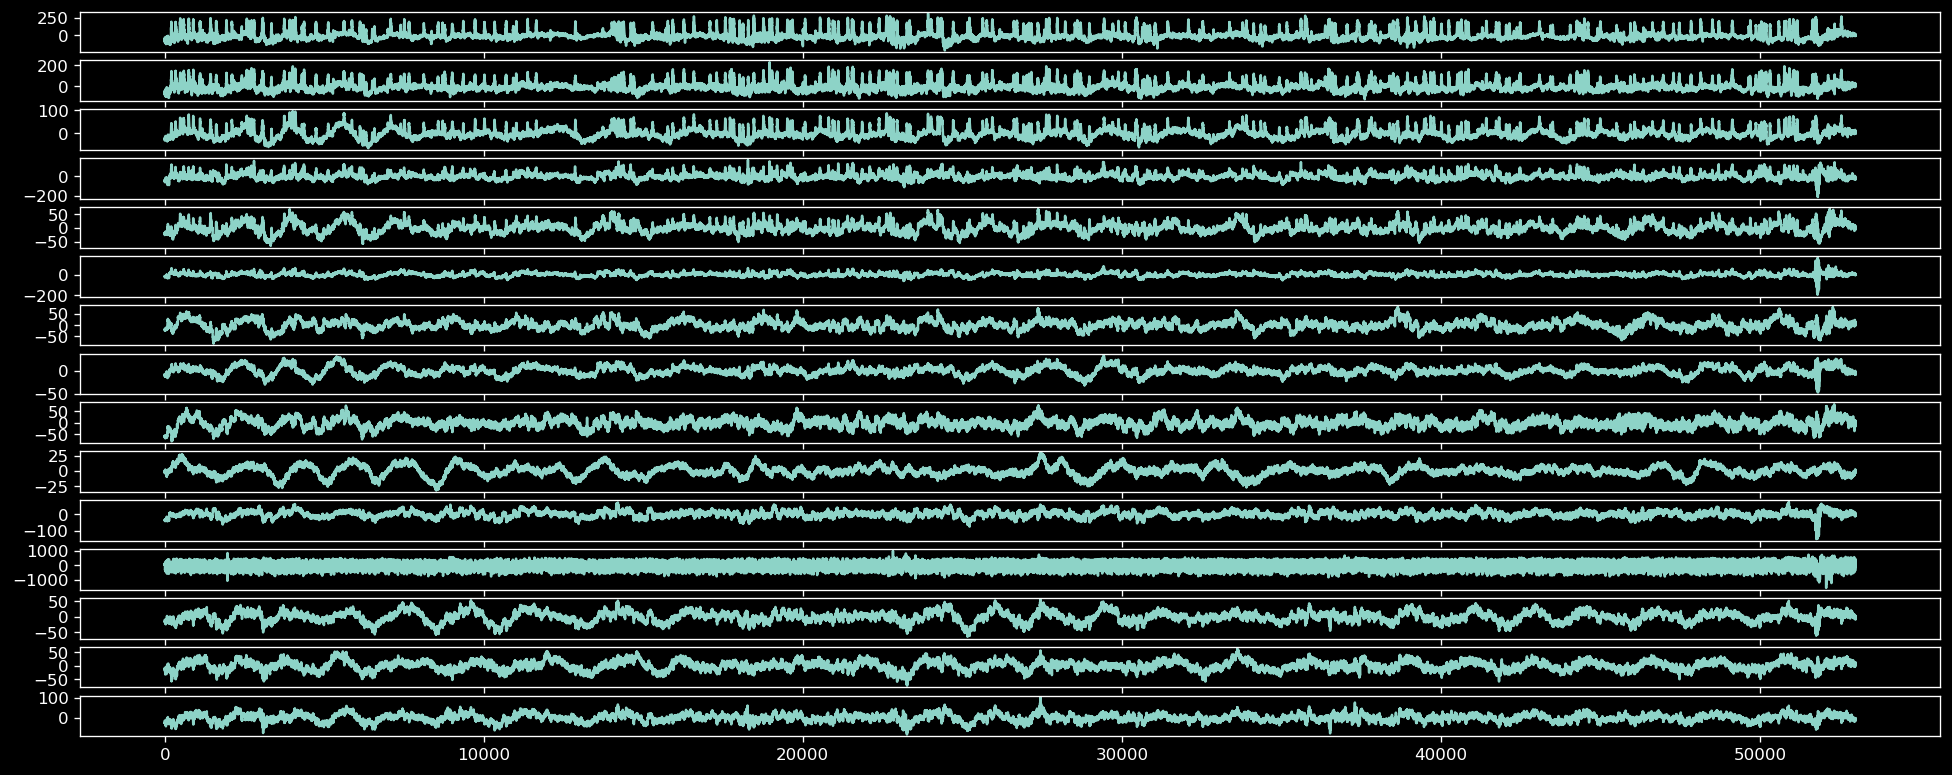

In [7]:
plt.figure(figsize=(20, 8), dpi=120)

plt.subplot(15,1,1)
plt.plot(exp['djc_eeg9'][0, :])

plt.subplot(15,1,2)
plt.plot(exp['djc_eeg9'][4, :])

plt.subplot(15,1,3)
plt.plot(exp['djc_eeg9'][8, :])

plt.subplot(15,1,4)
plt.plot(exp['djc_eeg9'][12, :])

plt.subplot(15,1,5)
plt.plot(exp['djc_eeg9'][16, :])

plt.subplot(15,1,6)
plt.plot(exp['djc_eeg9'][20, :])

plt.subplot(15,1,7)
plt.plot(exp['djc_eeg9'][24, :])

plt.subplot(15,1,8)
plt.plot(exp['djc_eeg9'][28, :])

plt.subplot(15,1,9)
plt.plot(exp['djc_eeg9'][32, :])

plt.subplot(15,1,10)
plt.plot(exp['djc_eeg9'][36, :])

plt.subplot(15,1,11)
plt.plot(exp['djc_eeg9'][40, :])

plt.subplot(15,1,12)
plt.plot(exp['djc_eeg9'][44, :])

plt.subplot(15,1,13)
plt.plot(exp['djc_eeg9'][48, :])

plt.subplot(15,1,14)
plt.plot(exp['djc_eeg9'][52, :])

plt.subplot(15,1,15)
plt.plot(exp['djc_eeg9'][56, :])

# plt.tight_layout()
plt.show()

### Cut the data to a unified length and save to file

In [11]:
exp = exp_all[18]
keys = list(exp.keys())
print(keys)

['__header__', '__version__', '__globals__', 'djc_eeg1', 'djc_eeg2', 'djc_eeg3', 'djc_eeg4', 'djc_eeg5', 'djc_eeg6', 'djc_eeg7', 'djc_eeg8', 'djc_eeg9', 'djc_eeg10', 'djc_eeg11', 'djc_eeg12', 'djc_eeg13', 'djc_eeg14', 'djc_eeg15']


In [12]:
recs = [exp[key] for key in keys if 'eeg' in key]
print(len(recs))
print(recs[0].shape)

15
(62, 47001)


In [13]:
eeg_recordings = torch.full(size=(nb_samples, 65, min_length), fill_value=12345.6789)
print(eeg_recordings.shape)

for i, exp in enumerate(exp_all):
    keys = list(exp.keys())
    recs = [exp[key] for key in keys if 'eeg' in key]
    for j, rec in enumerate(recs):
        sample = torch.from_numpy(rec[..., :min_length])
        nb_missing_ch = 65 - exp[keys[-1]].shape[0] 
        eeg_recordings[i*len(recs)+j] = torch.cat((sample, sample[:nb_missing_ch]), dim=0)

torch.Size([675, 65, 37001])


In [14]:
12345.6789 in eeg_recordings

False

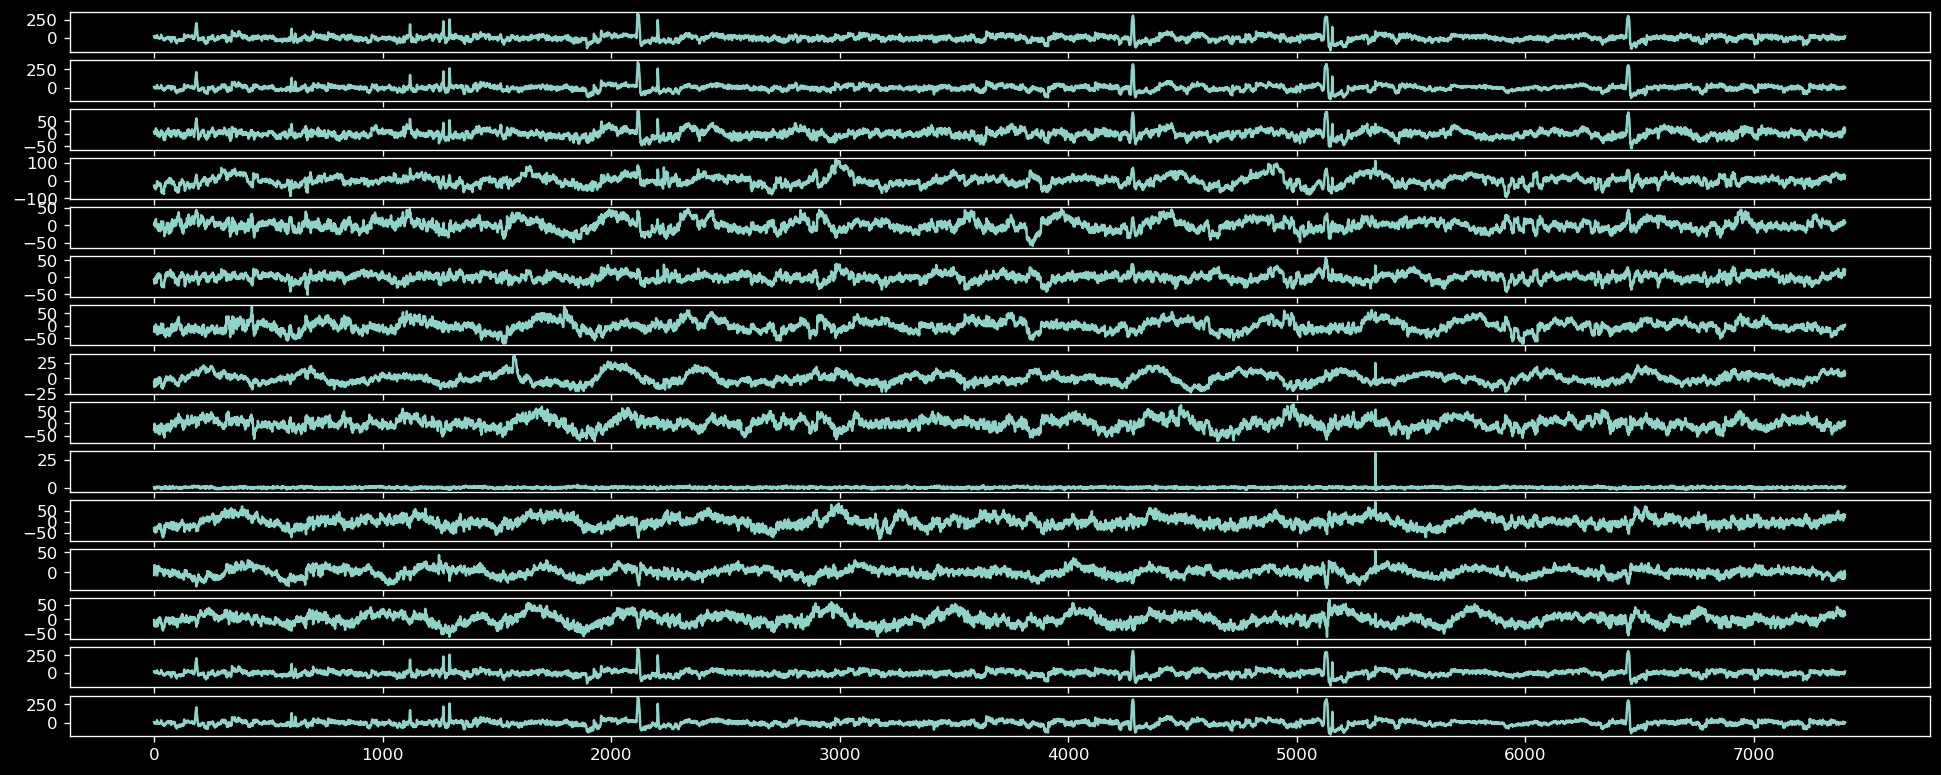

In [15]:
recording = int(18*15)-1

plt.figure(figsize=(20, 8), dpi=120)

plt.subplot(15,1,1)
plt.plot(eeg_recordings[recording, 0, ::5])

plt.subplot(15,1,2)
plt.plot(eeg_recordings[recording, 1, ::5])

plt.subplot(15,1,3)
plt.plot(eeg_recordings[recording, 8, ::5])

plt.subplot(15,1,4)
plt.plot(eeg_recordings[recording, 12, ::5])

plt.subplot(15,1,5)
plt.plot(eeg_recordings[recording, 16, ::5])

plt.subplot(15,1,6)
plt.plot(eeg_recordings[recording, 20, ::5])

plt.subplot(15,1,7)
plt.plot(eeg_recordings[recording, 24, ::5])

plt.subplot(15,1,8)
plt.plot(eeg_recordings[recording, 28, ::5])

plt.subplot(15,1,9)
plt.plot(eeg_recordings[recording, 32, ::5])

plt.subplot(15,1,10)
plt.plot(eeg_recordings[recording, 36, ::5])

plt.subplot(15,1,11)
plt.plot(eeg_recordings[recording, 40, ::5])

plt.subplot(15,1,12)
plt.plot(eeg_recordings[recording, 44, ::5])

plt.subplot(15,1,13)
plt.plot(eeg_recordings[recording, 48, ::5])

plt.subplot(15,1,14)
plt.plot(eeg_recordings[recording, 62, ::5])

plt.subplot(15,1,15)
plt.plot(eeg_recordings[recording, 63, ::5])

# plt.tight_layout()
plt.show()

In [16]:
# torch.save(eeg_recordings, os.path.join(os.getcwd(), '..', '..', 'preprocessed', f'data_SEED_fs200.pt'))

### Create the labels

There are fifiteen trials for each experiment. The labels of all trials are 1,0,-1,-1,0,1,-1,0,1,1,0,-1,0,1,-1, where 1 for positive, 0 for neutral and -1 for negative.
For more detailed description of this dataset, please see http://bcmi.sjtu.edu.cn/~seed/

In [30]:
import torch
import torch.nn.functional as F

In [49]:
labels = torch.Tensor([1, 0, 2, 2, 0, 1, 2, 0, 1, 1, 0, 2, 0, 1, 2]).to(torch.long).repeat(45)
print(labels[:15])

tensor([1, 0, 2, 2, 0, 1, 2, 0, 1, 1, 0, 2, 0, 1, 2])


In [50]:
labels = F.one_hot(labels, num_classes=3).float()
print(labels[:15])

tensor([[0., 1., 0.],
        [1., 0., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [1., 0., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [1., 0., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [1., 0., 0.],
        [0., 0., 1.],
        [1., 0., 0.],
        [0., 1., 0.],
        [0., 0., 1.]])


In [52]:
# torch.save(labels, os.path.join(os.getcwd(), '../..', 'preprocessed', f'labels_2classes_SEED_fs200.pt'))

In [55]:
# torch.load(os.path.join(os.getcwd(), '../..', 'preprocessed', f'labels_2classes_SEED_fs200.pt'))[:15]

tensor([[0., 1., 0.],
        [1., 0., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [1., 0., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [1., 0., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [1., 0., 0.],
        [0., 0., 1.],
        [1., 0., 0.],
        [0., 1., 0.],
        [0., 0., 1.]])

### Check the coordinates of the data

In [33]:
coords = pd.read_excel('SEED_EEG/channel-order.xlsx', header=None)
print(coords)

      0
0   FP1
1   FPZ
2   FP2
3   AF3
4   AF4
..  ...
57  CB1
58   O1
59   OZ
60   O2
61  CB2

[62 rows x 1 columns]


In [19]:
coords.values.squeeze()

array(['FP1', 'FPZ', 'FP2', 'AF3', 'AF4', 'F7', 'F5', 'F3', 'F1', 'FZ',
       'F2', 'F4', 'F6', 'F8', 'FT7', 'FC5', 'FC3', 'FC1', 'FCZ', 'FC2',
       'FC4', 'FC6', 'FT8', 'T7', 'C5', 'C3', 'C1', 'CZ', 'C2', 'C4',
       'C6', 'T8', 'TP7', 'CP5', 'CP3', 'CP1', 'CPZ', 'CP2', 'CP4', 'CP6',
       'TP8', 'P7', 'P5', 'P3', 'P1', 'PZ', 'P2', 'P4', 'P6', 'P8', 'PO7',
       'PO5', 'PO3', 'POZ', 'PO4', 'PO6', 'PO8', 'CB1', 'O1', 'OZ', 'O2',
       'CB2'], dtype=object)

In [20]:
ch_ordered = ['Fp1', 'Fpz', 'AF3', 'F3', 'F5', 'F7', 'FC1', 'FC3', 'FC5', 'FT7', 'FT9', 'C1', 'C3', 'C5', 'Cz', 'T7', 'CP1', 'CP3', 'CP5', 'TP7', 'TP9', 
 'P1', 'P3', 'P5', 'P7', 'Pz', 'PO3', 'PO7', 'PO9', 'POz', 'O1', 'Iz', 'LE', 'Fp2', 'AF4', 'F4', 'F6', 'F8', 'Fz', 'FC2', 'FC4', 'FC6', 'FT8', 'FT10', 
 'C2', 'C4', 'C6', 'T8', 'CP2', 'CP4', 'CP6', 'CPz', 'TP8', 'TP10', 'P2', 'P4', 'P6', 'P8', 'PO4', 'PO8', 'PO10', 'O2', 'Oz', 'RE']

In [25]:
np.asarray(ch_ordered).squeeze()

array(['Fp1', 'Fpz', 'AF3', 'F3', 'F5', 'F7', 'FC1', 'FC3', 'FC5', 'FT7',
       'FT9', 'C1', 'C3', 'C5', 'Cz', 'T7', 'CP1', 'CP3', 'CP5', 'TP7',
       'TP9', 'P1', 'P3', 'P5', 'P7', 'Pz', 'PO3', 'PO7', 'PO9', 'POz',
       'O1', 'Iz', 'LE', 'Fp2', 'AF4', 'F4', 'F6', 'F8', 'Fz', 'FC2',
       'FC4', 'FC6', 'FT8', 'FT10', 'C2', 'C4', 'C6', 'T8', 'CP2', 'CP4',
       'CP6', 'CPz', 'TP8', 'TP10', 'P2', 'P4', 'P6', 'P8', 'PO4', 'PO8',
       'PO10', 'O2', 'Oz', 'RE'], dtype='<U4')

In [32]:
for ch in coords.values.squeeze():
    if ch.lower() not in [ch.lower() for ch in ch_ordered]:
        print(ch)

F1
F2
FCZ
PO5
PO6
CB1
CB2
